# Desafio Técnico PDI 

📌 **OBJETIVO** - Considerando que a imagem em questão (encarte de supermercado) será processada por algoritmos de PDI e NLP, você como desenvolverdor do time de processamento de imagens tem a missão de aplicar à imagem algoritmos de pré-processamentos com o objetivo de destacar as regiões de interesse sabendo que cada oferta (nome e preço do produto) serão extraídos pelo time de NLP. Agora é com você, dev PDI ! Dado a imagem em anexo, escreva um código para aplicar os melhores pré-processamentos possíveis, preparando a imagem para o time de NLP.

> NUVEN - Núcleo de Visão Computacional e Engenharia

> Processo seletivo para a vaga **Desenvolvedor(a) em Processamento de Imagens**

> Andressa Gomes Moreira

**Importações**

In [1]:
import cv2
import numpy as np
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
from PIL import Image

**Carregamento da imagem analisada**

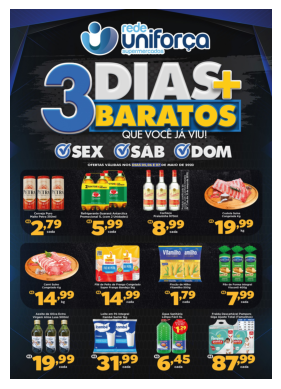

In [2]:
def carrega_imagem(path):
    """Carrega e exibe a imagem no formato RGB.

    Args:
        path (string): Caminho para imagem

    Returns:
        rgb: Retorna a imagem RGB
    """
    
    img = cv2.imread(path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(rgb);
    
    return rgb
    
rgb = carrega_imagem('./imagens/imagem_pdi.jpg')

In [3]:
rgb.shape

(2048, 1448, 3)

**Salvar as imagens**

In [4]:
def salva_imagem(path, img):
    """Salva a imagem processada no diretório.

    Args:
        path (string): Caminho para imagem
        img: Imagem resultante
    """
    cv2.imwrite(path, img)

### Pré-Processamento na imagem

**Área de Interesse**

> Primeiramente, é desejado gerar regiões de interesse (ROIs) da imagem (como nome e preço do produto) que serão extraídos em seguida.

In [5]:
def destaca_roi(img, rois):
    """Destaca as regiões de interesse (ROIs) da imagem.

    Args:
        img (numpy.ndarray - imagem): Imagem RGB
        rois (List): Coordenadas para destacar as regiões de interesse

    Returns:
        imagem_roi: Retorna a imagem com ROIs
    """
        
    imagem_roi = np.zeros_like(img)

    for roi in rois:
        x, y, w, h = roi  # Caixa delimitadora: (x, y, w=largura, h=altura)
        img_aux = img[y:y+h, x:x+w]
        imagem_roi[y:y+h, x:x+w] = img_aux
    
    return imagem_roi

def segmenta_imagem(imagem_roi):
    """Segmenta a imagem após destacar os ROIs.

    Args:
        imagem_roi (numpy.ndarray - imagem): Imagem com ROIs
        
    Returns:
        img_seg: Retorna a imagem segmentada
    """
        
    altura, largura, _ = imagem_roi.shape
    img_seg = imagem_roi[altura//2:altura, :]
    
    plt.axis('off')
    plt.imshow(img_seg);
    
    return img_seg

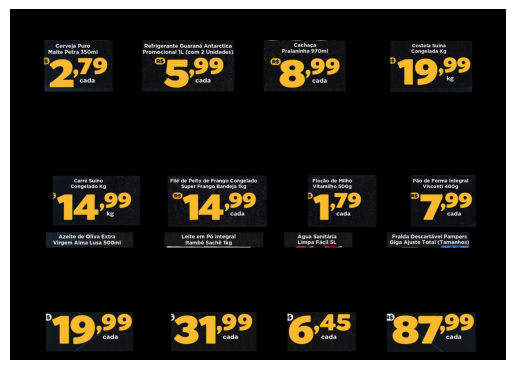

In [6]:
# Coordenadas das ROIs
rois = [
    (100, 1115, 200, 150),  
    (385, 1115, 270, 150),  
    (740, 1115, 240, 150),
    (1110, 1117, 240, 150),

    (125, 1510, 255, 145),  
    (460, 1510, 290, 150),  
    (870, 1510, 200, 150),
    (1170, 1510, 190, 150),

    (105, 1675, 255, 45),  
    (450, 1675, 290, 45),  
    (800, 1675, 200, 45),
    (1100, 1675, 240, 45),

    (105, 1908, 255, 115),  
    (470, 1908, 250, 115), 
    (810, 1908, 200, 115),
    (1100, 1910, 260, 115),
]

img_seg = segmenta_imagem(destaca_roi(rgb, rois))

In [7]:
salva_imagem('./imagens/imagem_segmentada.jpg', cv2.cvtColor(img_seg, cv2.COLOR_RGB2BGR))

**Converter imagens para tons de cinza**

> A maioria dos algoritmos esperam uma imagem na escala de cinza, por isso será realizada a conversão da imagem RGB para tons de cinza.

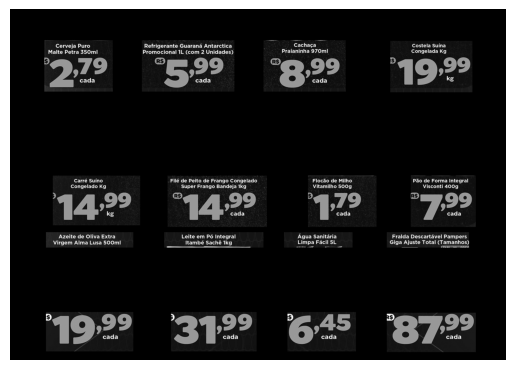

In [8]:
def converte_gray(img):
    """Converte a imagem RGB para tons de cinza.

    Args:
        img (numpy.ndarray - imagem): Imagem RGB

    Returns:
        rgb: Retorna a imagem em tons de cinza
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    plt.imshow(gray, cmap='gray');
    
    return gray

gray = converte_gray(img_seg)

In [9]:
gray.shape

(1024, 1448)

**Suavização da imagem**

> Para realizar a suavização da imagem e remover possíveis ruídos, será utilizado o filtro bilateral. O objetivo consiste em suavizar a imagem preservando os detalhes de bordas e contornos.	

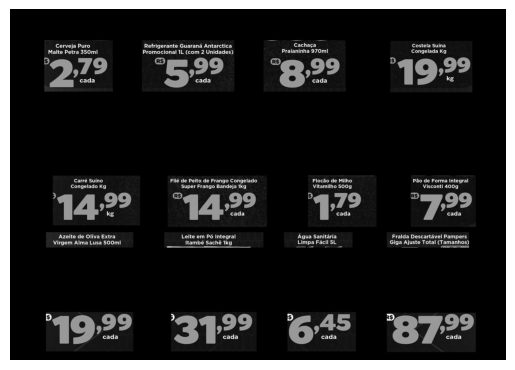

In [10]:
def suavizacao_bilateral(gray):
    """Realiza a suavização da imagem utilizando o filtro bilateral.

    Args:
        gray (numpy.ndarray - imagem): Imagem em tons de cinza

    Returns:
        img_suavizada: Retorna a imagem suavizada
    """
    
    img_suavizada = cv2.bilateralFilter(gray, 3, 75, 75) # cv2.GaussianBlur(gray, (3,3), 0)
    plt.axis('off')
    plt.imshow(img_suavizada, cmap='gray');
    
    return img_suavizada

img_suavizada = suavizacao_bilateral(gray)

**Binarização de Otsu**

> A binarização é realizada com objetivo de separar o objeto de interesse do fundo, podendo redefinir a região de interessa para a cor preta ou branca. Do contrário, o segundo plano é definido com a cor oposta. Foi utilizada a Binarização de Nobuyuki Otsu, na qual, é definido um limiar para realizar a binarização baseado no histograma da imagem.

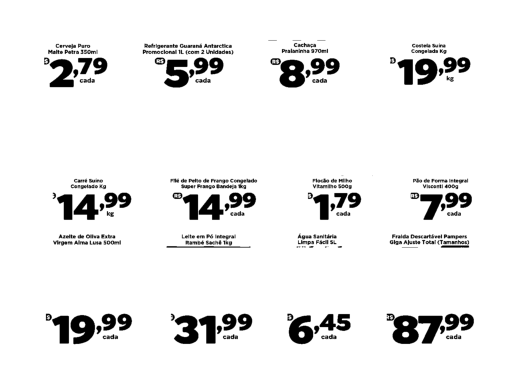

In [11]:
def binarizacao_otsu(img_suavizada):
    """Realiza a binarização da imagem pelo algoritmo Binarização de Nobuyuki Otsu.

    Args:
        img_suavizada (numpy.ndarray - imagem): Imagem suavizada em tons de cinza

    Returns:
        img_binarizada_otsu: Retorna a imagem binarizada
    """
    
    # Aplicar uma transformação de limiarização para segmentar os dígitos
    _, img_binarizada_otsu = cv2.threshold(img_suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    plt.axis('off')
    plt.imshow(img_binarizada_otsu, cmap='gray');
    
    return img_binarizada_otsu

img_binarizada_otsu = binarizacao_otsu(img_suavizada)

In [12]:
img_binarizada_otsu.shape

(1024, 1448)

In [13]:
cv2.imwrite('./imagens/imagem_resultado_processamento.jpg', img_binarizada_otsu)

True

### Extração de caracteres

> Para realizar a extração de caracteres é possível utilizar duas técnicas, usando pytesseract e o treinamento de redes neurais convolucionais.

> Para reconhecer o nome dos produtos é possível usar a biblioteca pytesseract. A imagem já encontra-se no formato adequado para ser reconhecida. Para melhorar a eficiência do pytesseract é possível destacar a área de interesse do texto.

> Os textes encontram-se no arquivo ***'reconhecimento_caracteres_pytesseract.ipynb'***.

In [14]:
def roi_pyt(img, coord):
    """Realiza a segmentação da imagem de acordo com o ROI desejado
    Args:
        img: Imagem a ser processada
        coord: coordenadas referentes a x, y, w, h
        
    Returns:
        bordas: Imagem Redmensionada
    """
    img_copy = img.copy()

    x, y, w, h = coord

    # Cortar a imagem
    roi = img_copy[y:y+h, x:x+w]

    # Redimensionar a imagem
    imagem_redimensionada = cv2.resize(roi, (w, h))

    plt.axis('off')
    plt.imshow(imagem_redimensionada, cmap='gray');
    
    return imagem_redimensionada

True

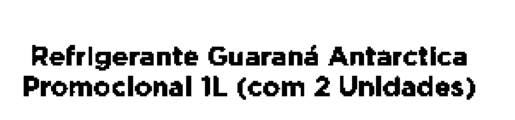

In [15]:
imagem_redimensionada1 = roi_pyt(img_binarizada_otsu, (380, 80, 290, 59))
cv2.imwrite('./imagens/imagem_entrada_pytesseract.jpg', imagem_redimensionada1)

### Preparação dos dados para Rede Neural

> O Pytesseract não mostrou-se tão eficiente ao extrair os dígitos referente ao preço dos produtos.

> Logo, para fazer a extração dos dígitos dos preços dos produtos texto será utilizada uma Rede Neural Convolucional.

> É necessário adaptar as imagens que serão enviadas para rede neural, pois, a rede será treinada com a base de dados MNIST e assim é interessante que a nossa imagem possua um formato semelhante, ou seja, a área de interesse (numeral) branca e o fundo preto.

> O treinamento da rede neural pode ser encontrado no arquivo ***'treinamento_CNN_OCR.ipynb'*** e o teste para a rede com as imagens dos preços do produto pode ser observado no arquivo ***'reconhecimento_numeros_cnn.ipynb'***

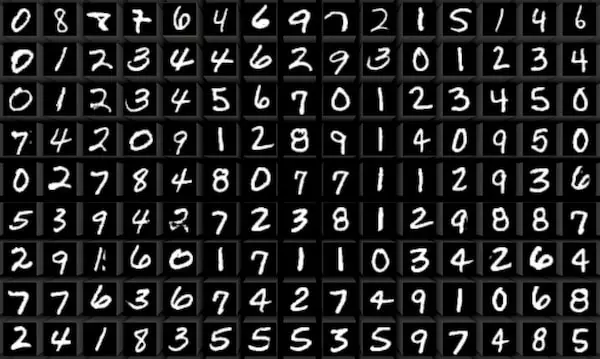

**Pré-processamento para rede neural**

**Seleciona um ROI para destacar um preço na imagem que será usado para testar a rede neural**

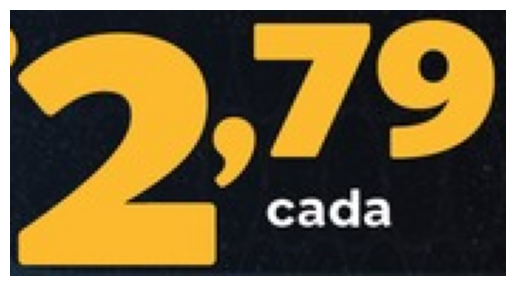

In [16]:
imagem_redimensionada5 = roi_pyt(img_seg, (113, 138, 175, 94))
salva_imagem('./imagens/img_seg_cnn_original.jpg', cv2.cvtColor(imagem_redimensionada5, cv2.COLOR_RGB2BGR))

**1) Transforma a imagem para escala de cinza**

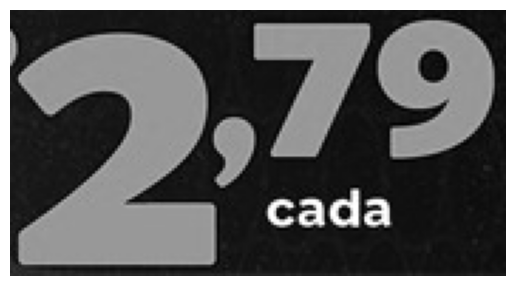

In [17]:
gray_seg_cnn = converte_gray(imagem_redimensionada5)

**2) Realiza a suavização da imagem**

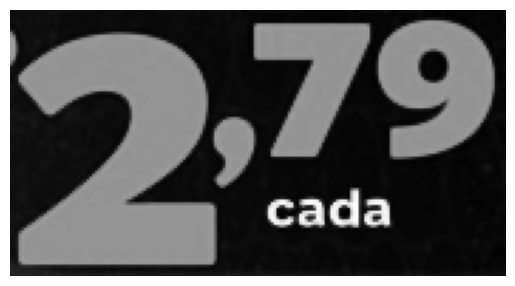

In [18]:
img_suavizada_seg_cnn = suavizacao_bilateral(gray_seg_cnn)

**3) Detecção das bordas com Filtro de Canny**

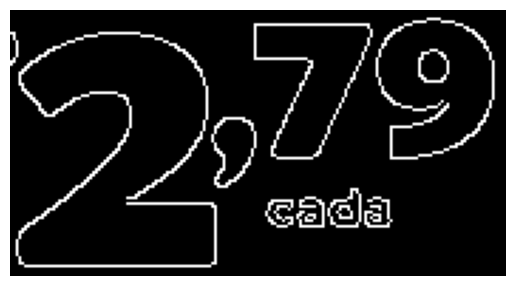

In [19]:
def canny(img):
    """Detecção das bordas da imagem pelo algoritmo Canny
    Args:
        img: Imagem a ser processada
        
    Returns:
        bordas: Retorna a imagem tratada
    """
    
    bordas = cv2.Canny(img, 40, 150)
    plt.axis('off')
    plt.imshow(bordas, cmap='gray');
    
    return bordas

img_canny = canny(img_suavizada_seg_cnn)

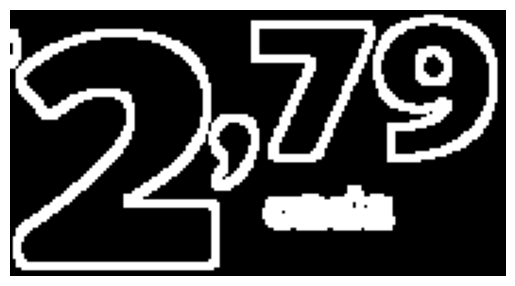

In [20]:
def dilatar_img(img):   
    """Realiza a operação morfológica de Dilatação na imagem.

    Args:
        img (numpy.ndarray - imagem): Imagem de entrada

    Returns:
        dilatado: Retorna a imagem após a operação de dilatação
    """
    
    dilatado = cv2.dilate(img, np.ones((3,3)))
    plt.axis('off')
    plt.imshow(dilatado, cmap='gray');
    
    return dilatado

img_dilatacao = dilatar_img(img_canny)

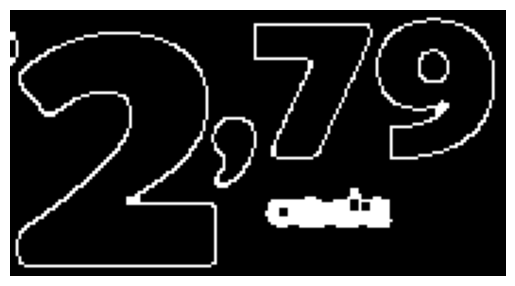

In [21]:
def erosao(img):   
    """Realiza a operação morfológica de Erosão na imagem.

    Args:
        img (numpy.ndarray - imagem): Imagem de entrada

    Returns:
        erosao: Retorna a imagem após a operação de erosão
    """
    erosao = cv2.erode(img, np.ones((3,3)))      
    plt.axis('off')
    plt.imshow(erosao, cmap='gray');
    
    return erosao

img_erosao = erosao(img_dilatacao)

In [22]:
salva_imagem('./imagens/img_cnn_erosao.jpg', img_erosao)